<a href="https://colab.research.google.com/github/tylerrwatsonn/comp551-mini4/blob/main/wide_sparse_nets_code_ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preliminaries

In [ ]:
import torch
import json
import os
import numpy as np
import matplotlib.pyplot as plt
parent_dir = os.path.abspath('')
print(parent_dir)
assert parent_dir == '/content' # if this statement fails, %cd into /content and rerun



/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#❗❗❗Create comp551-mini4 directory in your google drive


<a href="https://colab.research.google.com/github/tylerrwatsonn/comp551-mini4/blob/main/wide_sparse_nets_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Github code repo: https://github.com/google-research/wide-sparse-nets

In [ ]:
!git clone https://github.com/google-research/wide-sparse-nets.git

Cloning into 'wide-sparse-nets'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 28 (delta 2), reused 28 (delta 2), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [ ]:
%%capture
%cd wide-sparse-nets
!pip install -r requirements.txt

In [ ]:
%mv third_party/ ResNet18/ # this moves third_party to ResNet18 folder
%cd ResNet18
!python main.py --help

/content/wide-sparse-nets/ResNet18
usage: main.py [-h] [--seed SEED] [--half] [--workers WORKERS]
               [--optimizer OPTIMIZER] [--momentum M] [--wd WD]
               [--scheduler {multistep,cosine}] [--lr LR]
               [--num_epochs NUM_EPOCHS] [--dataset {cifar10,cifar100,svhn}]
               [--data_dir DATA_DIR] [--mbs MBS] [--model_name MODEL_NAME]
               [--base_width BASE_WIDTH] [--width WIDTH] [--io_only]

Training a ResNet18 on CIFAR or SVHN.

optional arguments:
  -h, --help            show this help message and exit
  --seed SEED           random seed
  --half                set model parameters to half precision (excluding BN
                        layers)
  --workers WORKERS     number of workers
  --optimizer OPTIMIZER
                        optimizer
  --momentum M          momentum
  --wd WD               weight decay (default: 5e-4)
  --scheduler {multistep,cosine}
                        lr scheduler
  --lr LR               initial learning r

In [ ]:
def train(model_name, base_width, widening_factors, num_epochs, mbs='128', lr='0.1', momentum='0.9'):
  stats = {}
  base_width_str = str(base_width)
  num_epochs_str = str(num_epochs)
  for factor in widening_factors:
    width = int(base_width * factor)
    width_str = str(width)
    print(f'Starting training for base_width: {base_width} and widening_factor: {factor} ({width})...')
    !python -m main --seed 888 --dataset cifar100 --base_width {base_width_str} --width {width_str} --num_epochs {num_epochs_str} --model_name {model_name} --mbs {mbs} --lr {lr} --momentum {momentum}
    print('Finished training')
    run_stats = torch.load(f'runs/cifar100_{model_name}_{base_width}_{width}_mbs_{mbs}_lr_{lr}_seed_888/stats.pt')
    stats[str(factor)] = run_stats
    # save backups after finishing a model
    with open(f'/content/drive/MyDrive/comp551-mini4/cifar100_{model_name}_base_width_{base_width}_num_epochs_{num_epochs}_mbs_{mbs}_lr_{lr}_mom_{momentum}_factor_{factor}.json', 'w') as f:
      json.dump(run_stats, f, indent=4)
  with open(f'/content/drive/MyDrive/comp551-mini4/cifar100_{model_name}_base_width_{base_width}_num_epochs_{num_epochs}_mbs_{mbs}_lr_{lr}_mom_{momentum}.json', 'w') as f:
    json.dump(stats, f, indent=4)


In [ ]:
WIDENING_FACTORS = [1, 1.5, 2.2, 3.3, 5]

base_width = 8
num_epochs = 20
train('senet18', base_width, WIDENING_FACTORS, num_epochs)

In [ ]:
WIDENING_FACTORS = [1, 1.5, 2.2, 3.3, 5]

base_width = 8
num_epochs = 20
train('resnet18', base_width, WIDENING_FACTORS, num_epochs, mbs='32', lr='0.01', momentum='0.8')

In [ ]:
# Rename loaded file based on where results from previous run are saved (see output of code chunk above)
stats = torch.load('runs/cifar100_resnet18_4_8_mbs_128_lr_0.1_seed_888/stats.pt')
print(json.dumps(stats, indent=4))
with open('/content/drive/MyDrive/resnet/cifar100_resnet18_4_8_mbs_128_lr_0.1_seed_888.json', 'w') as f:
    json.dump(stats, f, indent=4)

In [ ]:
def get_train_results_last_epoch(train_results_json, widening_factors, num_epochs):
  test_accs = []
  train_accs = []
  for factor in widening_factors:
    test_accs.append(train_results_json.get(str(factor), {}).get('acc1', {}).get(str(num_epochs - 1), {}).get('test'))
    train_accs.append(train_results_json.get(str(factor), {}).get('acc1', {}).get(str(num_epochs - 1), {}).get('train'))
  return test_accs, train_accs

def get_train_results_max_epoch(train_results_json, widening_factors, num_epochs):
  test_accs = []
  train_accs = []
  for factor in widening_factors:
    acc1 = train_results_json.get(str(factor), {}).get('acc1', {})
    max_test_acc = 0
    for epoch in acc1:
      if acc1[str(epoch)]['test'] > max_test_acc:
        max_test_acc = acc1[str(epoch)]['test']
    max_train_acc = 0
    for epoch in acc1:
      if acc1[str(epoch)]['train'] > max_train_acc:
        max_train_acc = acc1[str(epoch)]['train']
    test_accs.append(max_test_acc)
    train_accs.append(max_train_acc)
  return test_accs, train_accs

def plot_results(widening_factors, accs_ls, labels, xlabel, ylabel):
  for i, accs in enumerate(accs_ls):
    plt.plot(widening_factors, accs, label = f'{labels[i]}')
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()

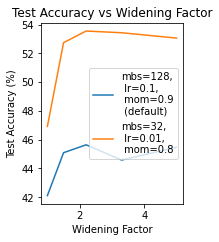

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
widening_factors = [1, 1.5, 2.2, 3.3, 5]

with open('/content/drive/MyDrive/comp551-mini4/cifar100_resnet18_base_width_8.json', 'r') as f:
  base_width_8_json = json.load(f)

test_accs_8, train_accs_8 = get_train_results_max_epoch(base_width_8_json, WIDENING_FACTORS, 20)
# plot_results(WIDENING_FACTORS, [test_accs_8], [8])

with open('/content/drive/MyDrive/comp551-mini4/cifar100_resnet18_base_width_8_num_epochs_20_mbs_32_lr_0.01_mom_0.8.json', 'r') as f:
  base_width_8_json = json.load(f)

test_accs_8_senet, train_accs_8_senet = get_train_results_max_epoch(base_width_8_json, WIDENING_FACTORS, 20)
plot_results(WIDENING_FACTORS, [test_accs_8, test_accs_8_senet], ['ResNet18', 'SENet18'], 'Widening Factor', 'Test Accuracy (%)')
plot_results(WIDENING_FACTORS, [train_accs_8, train_accs_8_senet], ['ResNet18', 'SENet18'], 'Widening Factor', 'Train Accuracy (%)')

labels = ['mbs=128,\n lr=0.1,\n mom=0.9\n (default)', 'mbs=32,\n lr=0.01,\n mom=0.8']
# plt.subplot(1,2,1)
# for i, accs in enumerate([train_accs_8, train_accs_8_senet]):
#   plt.plot(widening_factors, accs, label = f'{labels[i]}')
# plt.title('Train Accuracy vs Widening Factor')

# plt.xlabel('Widening Factor')
# plt.ylabel('Train Accuracy (%)')
# plt.legend()

plt.subplot(1,2,2)
for i, accs in enumerate([test_accs_8, test_accs_8_senet]):
  plt.plot(widening_factors, accs, label = f'{labels[i]}')
plt.title('Test Accuracy vs Widening Factor')
plt.xlabel('Widening Factor')
plt.ylabel('Test Accuracy (%)')
plt.legend()

plt.tight_layout(pad=3)
plt.show()